In [12]:
import pandas as pd
import MyLib.nlp as nlp
import MyLib.HTML_prep as HTML_prep
import MyLib.analysis as analysis 
import MyLib.hype as hype 
from ipywidgets import interactive, interact

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Import Files & group by date


In [28]:
freq="M"
df=pd.read_json("2023-06-06_Zotero_AI_nlp_en2.json")
print("total:", len(df))

df_publ=df.drop_duplicates(subset="FileKey")[["date","FileKey"]]
df_publ=df_publ.set_index("date").groupby(pd.Grouper(freq=freq)).count()
df_publ.columns=["Publications"]
df_publ.tail()

total: 1622


,Publications
date,
2023-02-28,27
2023-03-31,39
2023-04-30,45
2023-05-31,52
2023-06-30,17


# 2. Most common words

In [110]:
# ChatGPT_Terms="ChatGPT, GPT3, GPT4, OpenAI, AI, LLM, A.I, GPT, Chatbot, technology, tool, app, Artificial Intelligence, Large Language Models"


In [29]:
df["NoStopwords_Set"]=df.NoStopwords.apply(lambda x: list(x))
Lists=df.NoStopwords_Set.to_list()


[('ai', 2642), ('chatgpt', 1762), ('chatbot', 1611), ('human', 975), ('work', 963), ('research', 922), ('student', 870), ('use', 852), ('datum', 787), ('university', 713), ('system', 676), ('information', 665), ('technology', 605), ('example', 558), ('new', 553)]


<AxesSubplot: ylabel='word'>

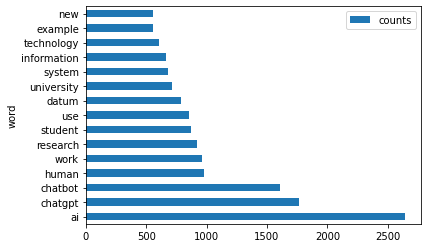

In [30]:
Lists=df.NoStopwords.to_list()

Lists=[i for i in Lists if i!=None]
Words=[item for sublist in Lists for item in sublist]

from collections import Counter
a_counter = Counter(Words)
most_common = a_counter.most_common(15)

print(most_common)#, most_common2)
pd.DataFrame.from_records(most_common,columns=["word","counts"],index="word").plot.barh()

# Finding the most hyping universities, articles, and sentences

In [31]:
from nltk.tokenize import sent_tokenize

#Find sentences


df["AI_sentences"]=df.AI_paragraphs.apply(sent_tokenize)
df=df.explode("AI_sentences").drop_duplicates(subset=["AI_sentences"]).dropna(subset=["AI_sentences"]).reset_index()


In [112]:
# Redo the NLP for AI Sentences as the DF structure changed (explode)
df_Sentences=nlp.NLP_Pipeline(df, sentiment=False, language="en",translate=False, column="AI_sentences")

Current Time = 12:21:28
Lenght:  5807
cleaning done.
Current Time = 12:21:30
Current Time = 12:22:26
language detection done.
pure english text done. Next: Token & Lemmatizing.
Current Time = 12:22:26
Token & Lemmatizing done. Next: Remove Stopwords.
Current Time = 12:24:03
Current Time = 12:24:03


In [114]:
df_Sentences.to_json("2023-06-14_HypeSentences.json")

In [5]:
df_Sentences=pd.read_json("2023-06-14_HypeSentences.json")


#df_test["NER"]=df_test.AI_sentences.apply(NER)

In [32]:
# 1. Select Wordlist: here - from my hype library module (see Miller et al.)
hype_selection=hype.hype_selection # OR: hype.Key_hypes

df["hype_word"]=df.AI_sentences.apply(hype.hype_word,keys=hype_selection)
df["hype_sentence"]=df.AI_sentences.apply(hype.hype_sentence,keys=hype_selection)


df["modal_word"]=df.AI_sentences.apply(hype.hype_word,keys=hype.key_modal)
df["modal_sentence"]=df.AI_sentences.apply(hype.hype_sentence,keys=hype.key_modal)
df["modal_n"]=df.modal_word.apply(lambda x: len(x) if isinstance(x,list) else 0)


df["hype_n"]=df.hype_word.apply(lambda x: len(x) if isinstance(x,list) else 0)
#df=df.sort_values("hype_n", ascending=False).drop_duplicates(subset="AI_sentences")



In [35]:
df=df.sort_values("modal_n", ascending=False)#.drop_duplicates(subset="modal_sentences")
df[["modal_word","modal_sentence","modal_n"]].head()

,modal_word,modal_sentence,modal_n
1990,"[would, might, will, want, would like to]",[A consortium co-leadership is also a possibil...,5
1993,"[would, will, can, may, would like to]","[Of course, you are also free to shape this ou...",5
5591,"[could, need, can, want]","[Specifically, chatbots’ ability to learn from...",4
1970,"[let, should, can, believe]",[Utrecht University believes it is important t...,4
3594,"[will, can, may, ought]","[pendent thinking, so that we can step in when...",4


In [28]:
df[["hype_word","hype_sentence","hype_n"]].head()

,hype_word,hype_sentence,hype_n
2591,"[important, novel, effectively]",[This shift has offered the opportunity to exp...,3
2358,"[notable, innovative, particularly]",[Can you discuss any particularly innovative o...,3
2659,"[important, highlight]",[One highlight from this project included secu...,2
50,"[important, relevant]",[Text generation can play a major part in this...,2
467,"[importance, highlight]",[Our speakers will also highlight the importan...,2


# Named entity recognition of hype sentences

In [31]:
df_test=df[df.language=="en"].explode(column="hype_sentence")[:20]

def NER(RAW_text):
    import spacy
    from spacy import displacy

    NER = spacy.load("en_core_web_sm")
    text=NER(RAW_text)

    text=[(word.text, word.label_) for word in text.ents]
    
    return text


df_test["NER"]=df_test.AI_sentences.apply(NER)
df_test["NER"]

2591                                                   []
2358    [(centre?One, CARDINAL), (the EUR Smart Campus...
2659    [(One, CARDINAL), (three, CARDINAL), (just fou...
50                                                     []
467                                           [(AI, ORG)]
2785                                                   []
2374                    [(recent years, DATE), (AI, ORG)]
230                                                    []
1447                                                   []
4153                                  [(Vincent, PERSON)]
2376                    [(AI, ORG), (AI, ORG), (AI, ORG)]
4177                                  [(Vincent, PERSON)]
5591                                                   []
3163                    [(ChatLab, ORG), (two, CARDINAL)]
2683    [(EUR, ORG), (AI, ORG), (ERS Business Developm...
3127                    [(ChatLab, ORG), (two, CARDINAL)]
2409                    [(recent years, DATE), (AI, ORG)]
3474    [(Chat

In [32]:
pd.set_option('display.max_colwidth', None)
[i for i in df_test["NER"]]

[[],
 [('centre?One', 'CARDINAL'),
  ('the EUR Smart Campus Project', 'ORG'),
  ('Opens', 'ORG')],
 [('One', 'CARDINAL'),
  ('three', 'CARDINAL'),
  ('just four days', 'DATE'),
  ('5', 'CARDINAL'),
  ('European', 'NORP'),
  ('EUR', 'ORG'),
  ('TU Delft', 'ORG'),
  ('Zuid', 'GPE'),
  ('Holland', 'GPE'),
  ('NWO', 'ORG'),
  ('EUR', 'ORG'),
  ('first', 'ORDINAL'),
  ('2', 'CARDINAL')],
 [],
 [('AI', 'ORG')],
 [],
 [('recent years', 'DATE'), ('AI', 'ORG')],
 [],
 [],
 [('Vincent', 'PERSON')],
 [('AI', 'ORG'), ('AI', 'ORG'), ('AI', 'ORG')],
 [('Vincent', 'PERSON')],
 [],
 [('ChatLab', 'ORG'), ('two', 'CARDINAL')],
 [('EUR', 'ORG'),
  ('AI', 'ORG'),
  ('ERS Business Development & Knowledge Transfer Team', 'ORG')],
 [('ChatLab', 'ORG'), ('two', 'CARDINAL')],
 [('recent years', 'DATE'), ('AI', 'ORG')],
 [('ChatGPT', 'ORG'), ('Google', 'ORG'), ('one', 'CARDINAL'), ('AI', 'ORG')],
 [('the Centre of Expertise in Learning & Teaching', 'ORG'),
  ('one', 'CARDINAL'),
  ('AI', 'ORG'),
  ('AI', 'ORG')

# Hype-word statistics per university

In [33]:

Counts=pd.DataFrame({"publications": df.drop_duplicates(subset="FileKey").value_counts("Uni"), 
                     "sentences":df.value_counts("Uni"),
                    "hypewords":df.groupby("Uni").sum()["hype_n"]})
Counts["mean hype-words"]=Counts["hypewords"]/Counts["sentences"]
Counts

,publications,sentences,hypewords,mean hype-words
Uni,,,,
Delft University,22,331,13,0.039275
Eindhoven University of Technoloy,27,770,29,0.037662
Leiden University,40,428,19,0.044393
Maastricht Univerisity,26,494,36,0.072874
OpenUniversiteitNederland,12,119,1,0.008403
Radboud Nijmegen,28,374,19,0.050802
Rotterdam University,29,493,82,0.166329
Tilburg University,12,234,13,0.055556
University of Amsterdam,24,304,29,0.095395


# Check hype sentences

In [34]:
pd.options.display.max_colwidth = 500
hype_sentences=df.iloc[:12,-4:]
hype_sentences
hype_sentences.to_excel("hype_sentences.xlsx")

In [40]:
hype_sentences=df[['Uni','date',"hype_n","AI_sentences",'word_count','hype_word']]
#hype_sentences["hype_ratio"]=hype_sentences["hype_n"]/hype_sentences["word_count"]
#hype_sentences.drop_duplicates(subset="AI_sentences")
hype_sentences.sort_values(by="hype_n", ascending=False).head(10)

,Uni,date,hype_n,AI_sentences,word_count,hype_word
2358,Rotterdam University,2023-04-25,3,Can you discuss any particularly innovative or...,712,"[notable, innovative, particularly]"
2591,Rotterdam University,2022-05-24,3,This shift has offered the opportunity to expa...,72,"[important, novel, effectively]"
230,Radboud Nijmegen,2023-04-01,2,Will ChatGPT fundamentally change our educatio...,60,"[fundamentally, fundamental]"
3428,Vrije Universiteit Amsterdam,2023-02-10,2,It will significantly change many aspects of o...,150,"[significant, significantly]"
3474,Vrije Universiteit Amsterdam,2023-02-24,2,ChatGPT's sophisticated features therefore ope...,728,"[essential, disrupt]"
3581,Vrije Universiteit Amsterdam,2023-02-24,2,This creates a double risk: not only may human...,755,"[essential, especially]"
4885,Maastricht Univerisity,2023-01-30,2,The most notable of these disruptions came fro...,61,"[notable, disrupt]"
309,Radboud Nijmegen,2023-04-26,2,By exploring how AI can complement and enhance...,56,"[effectively, empower]"
3513,Vrije Universiteit Amsterdam,2023-02-24,2,This creates a double risk: not only may human...,757,"[essential, especially]"
1236,University of Twente,2023-06-05,2,To help you see the potential risk in your typ...,304,"[relevant, especially]"


In [37]:
df.columns

Index(['index', 'Uni', 'FileKey', 'url', 'date', 'Title', 'linkName',
       'linkUrl', 'AI_paragraphs', 'text_clean', 'letters_count', 'word_count',
       'language', 'source_language', 'pure_text', 'Lemmata', 'NoStopwords',
       'NoStopwords_Set', 'AI_sentences', 'hype_word', 'hype_sentence',
       'modal_word', 'modal_sentence', 'modal_n', 'hype_n'],
      dtype='object')

C:\Users\mr\AppData\Local\Temp\ipykernel_14584\3206164115.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  modal_df[modal_df.index>pd.datetime(2022,1,1)]["modal_word"].plot(title=f"n_modal_words peer {freq}",legend=True)


<AxesSubplot: title={'center': 'n_modal_words peer M'}, xlabel='date'>

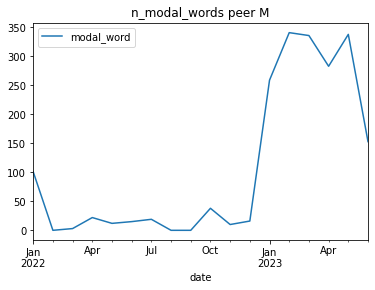

In [38]:
freq="M"

hype_time=df.set_index("date").groupby(pd.Grouper(freq=freq))


modal_df=pd.DataFrame()
modal_df["modal_word"]=hype_time["modal_n"].apply(lambda x: sum(x) if len(x)>0 else 0)
#hype_df["n"]=hype_time["hype_n"].apply(lambda x: len(x) if len(x)>0 else 0)

modal_df[modal_df.index>pd.datetime(2022,1,1)]["modal_word"].plot(title=f"n_modal_words peer {freq}",legend=True)

In [44]:
hype.key_modal

['let',
 'would',
 'might',
 'urge',
 'will',
 'could',
 'should',
 'ask for',
 'need',
 'can',
 'wish',
 'doubt',
 'must',
 'aim',
 'may',
 'want',
 'would like to',
 'believe',
 'expect',
 'have to',
 'hope',
 'fear',
 'ought']

C:\Users\mr\AppData\Local\Temp\ipykernel_14584\2412460925.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  hype_df[hype_df.index>pd.datetime(2022,6,1)]["Hypewords"].plot(title=f"n_hypewords peer {freq}",legend=True)
C:\Users\mr\AppData\Local\Temp\ipykernel_14584\2412460925.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df_publ[df_publ.index>pd.datetime(2022,6,1)]["Publications"].plot(legend=True)
C:\Users\mr\AppData\Local\Temp\ipykernel_14584\2412460925.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  modal_df[modal_df.index>pd.datetime(2022,6,1)]["modal_word"].plot(title=f"n_modal_words peer {freq}",legend=True, secondary_y=True)


<AxesSubplot: >

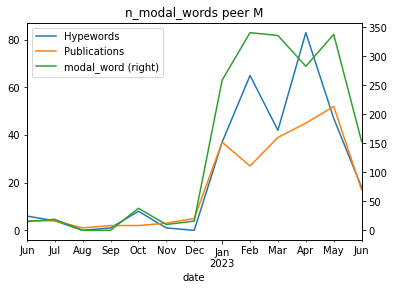

In [43]:
freq="M"

hype_time=hype_sentences.set_index("date").groupby(pd.Grouper(freq=freq))


hype_df=pd.DataFrame()
hype_df["Hypewords"]=hype_time["hype_n"].apply(lambda x: sum(x) if len(x)>0 else 0)
#hype_df["n"]=hype_time["hype_n"].apply(lambda x: len(x) if len(x)>0 else 0)

hype_df[hype_df.index>pd.datetime(2022,6,1)]["Hypewords"].plot(title=f"n_hypewords peer {freq}",legend=True)
df_publ[df_publ.index>pd.datetime(2022,6,1)]["Publications"].plot(legend=True)
modal_df[modal_df.index>pd.datetime(2022,6,1)]["modal_word"].plot(title=f"n_modal_words peer {freq}",legend=True, secondary_y=True)

In [37]:
hype_time=hype_sentences.set_index("date").groupby(pd.Grouper(freq='W'))
hype_time

# Use of words over time

In [38]:
from collections import Counter


keyWords="chatgpt,education,chatbot,university,create,write,produce,answer,tool,human,skill,knowledge,bias,assignment,intelligence,artificial,test,evaluate,assessment,plagiarism"
keyWords="education,chatbot,create,write,produce,answer,tool,human,skill,knowledge,bias,assignment,intelligence,artificial,test,evaluate,assessment,plagiarism"

keyWords=keyWords.split(",")
print(keyWords)

group=df.set_index("date").groupby(pd.Grouper(freq='M'))["NoStopwords"].sum()

Wordyear={}
Wordyear_exact={}
Wordyear_only={}
for i, row in group.iteritems():
    
    #print(i,row)
    if type(row)==list:
        
        ## filter ROW for interesting key-words:
        row=[i for i in row if i in keyWords]
        
        c=Counter(row).most_common(5)
        
        c_exact=[(i[0],i[1]/len(group)) for i in c]

        c=[(i[0],str(round(i[1]/len(group)*100,2))+"%") for i in c]
        c_only=[i[0] for i in c]


        Wordyear[str(i)]=c
        Wordyear_exact[str(i)]=c_exact
        Wordyear_only[str(i)]=c_only
        
        
        
    #print(c,"\n")
    
CountDF=pd.DataFrame.from_dict(Wordyear, orient='index').T


CountDF.T[CountDF.T.index>"2022-10-01"]

['education', 'chatbot', 'create', 'write', 'produce', 'answer', 'tool', 'human', 'skill', 'knowledge', 'bias', 'assignment', 'intelligence', 'artificial', 'test', 'evaluate', 'assessment', 'plagiarism']


,0,1,2,3,4
2022-10-31 00:00:00,"(knowledge, 79.93%)","(artificial, 31.29%)","(intelligence, 31.29%)","(create, 11.9%)","(chatbot, 8.16%)"
2022-11-30 00:00:00,"(chatbot, 12.59%)",None,None,None,None
2022-12-31 00:00:00,"(write, 36.39%)","(answer, 16.67%)","(human, 10.88%)","(artificial, 7.82%)","(intelligence, 7.82%)"
2023-01-31 00:00:00,"(write, 113.27%)","(tool, 111.22%)","(answer, 102.72%)","(chatbot, 100.34%)","(human, 94.22%)"
2023-02-28 00:00:00,"(chatbot, 607.82%)","(human, 521.43%)","(write, 228.23%)","(knowledge, 148.64%)","(skill, 124.15%)"
2023-03-31 00:00:00,"(answer, 471.09%)","(chatbot, 399.32%)","(write, 327.55%)","(create, 182.99%)","(tool, 176.19%)"
2023-04-30 00:00:00,"(human, 151.7%)","(create, 149.66%)","(education, 141.84%)","(knowledge, 126.87%)","(intelligence, 72.45%)"
2023-05-31 00:00:00,"(education, 185.03%)","(intelligence, 177.55%)","(artificial, 171.77%)","(chatbot, 156.8%)","(write, 131.63%)"
2023-06-30 00:00:00,"(intelligence, 159.18%)","(artificial, 124.49%)","(education, 84.35%)","(human, 78.23%)","(write, 54.08%)"


In [53]:
CountDF=pd.DataFrame.from_dict(Wordyear_only, orient='index').T
CountDF.T[CountDF.T.index>"2022-10-01"]

,0,1,2,3,4
2022-10-31 00:00:00,knowledge,artificial,intelligence,create,chatbot
2022-11-30 00:00:00,chatbot,None,None,None,None
2022-12-31 00:00:00,write,answer,human,skill,artificial
2023-01-31 00:00:00,write,tool,answer,chatbot,human
2023-02-28 00:00:00,chatbot,human,write,knowledge,skill
2023-03-31 00:00:00,answer,chatbot,write,create,tool
2023-04-30 00:00:00,human,create,education,knowledge,intelligence
2023-05-31 00:00:00,education,intelligence,artificial,chatbot,write
2023-06-30 00:00:00,intelligence,artificial,education,human,write


In [54]:
#df=df.drop_duplicates("text_clean")

# Words in context & Word-Graph analysis

In [116]:
#This cell allows to read the words before and after a search_word. You can change the searchword & the size of the context.
@interact(search_word="education",words_before=(0,10),words_after=(0,10))
def text_context(column=["text_clean","pure_text","NoStopwords","AI_sentences"],search_word="education",words_before=1,words_after=1):
    df_Sentences[column].dropna().apply(analysis.Keyword_context,search_word=search_word.lower(),context=(words_before,words_after))


interactive(children=(Dropdown(description='column', options=('text_clean', 'pure_text', 'NoStopwords', 'AI_se…

In [126]:
# WORD _GRAPH ANALYSIS

G=analysis.Word_NetworkGen(df_Sentences,n=500,column="NoStopwords")
G2=analysis.CleanGraph(G,removeIsolates=True,minDegree=2,only_largest_component=True)
#G2=G
analysis.writeNetworkHTML(G2,view=False)
print("see the network: The_network.html")

[(('topic', 'research'), 335), (('ai', 'ai'), 316), (('list', 'research'), 282), (('topic', 'topic'), 259), (('university', 'university'), 255)]
Cleaning Graph to minimum Degree 2.
Nodes count:  85
Edges count:  357
see the network: The_network.html


In [128]:
Centrality=pd.DataFrame(nx.closeness_centrality(G), index=[0]).T.sort_values(by=0,ascending=False)

Centrality.columns=["closeness-Centrality_per_sentence"]
Centrality.head(10)

,closeness-Centrality_per_sentence
ai,0.572495
research,0.528737
university,0.512418
topic,0.488304
concept,0.485449
list,0.463753
student,0.461176
create,0.461176
chatgpt,0.461176
work,0.446300


In [129]:
import networkx as nx
nx.write_gexf(G, "NoStopwords.gexf")

# Link Analysis 

In [39]:
import networkx as nx

df=pd.read_json("2023-06-06_Zotero_AI_nlp_en2.json")
links=df[["url","linkUrl"]].drop_duplicates(subset="url").explode("linkUrl")

In [40]:
def domain_From_url(url):
    if isinstance(url,str):
        domain=url.replace("https://","").replace("http://","").replace("www.","").split("/")[0].lstrip(".")
        domain=domain.rsplit("@",1)[-1].rsplit("%20",1)[-1]
        if domain.count(".")>1:
            domain=".".join(domain.rsplit(".",2)[-2:])

        if "." in domain:
            return domain
    
    


links["source"]=links.url.apply(domain_From_url)
links["target"]=links.linkUrl.apply(domain_From_url).reindex()

In [41]:
links=links.dropna(subset="target").dropna(subset="source")
links=links[~links["url"].apply(lambda x: "linkedin.com" in x)]
edgelist=(zip(links["source"], links["target"]))

links[links["source"]==None]
G = nx.from_edgelist(edgelist)
nx.write_gexf(G,"Links.gexf")
Link_Centrality=pd.DataFrame(nx.closeness_centrality(G),index=[0]).T.sort_values(ascending=False, by=0)
Link_Centrality.columns=["Centrality"]
Link_Centrality.head(10)

,Centrality
openai.com,0.436815
linkedin.com,0.418636
youtube.com,0.413075
facebook.com,0.410595
rug.nl,0.391782
twitter.com,0.388666
uu.nl,0.381300
uva.nl,0.375440
ru.nl,0.369358
tudelft.nl,0.368562


In [42]:
edgelist=(zip(links["source"], links["target"]))
edges=list(edgelist)

In [43]:
from collections import Counter
pd.DataFrame(Counter(edges).most_common(15))

,0,1
0,"(vu.nl, vu.nl)",229
1,"(tudelft.nl, tudelft.nl)",188
2,"(uu.nl, uu.nl)",171
3,"(utwente.nl, utwente.nl)",155
4,"(ru.nl, ru.nl)",128
5,"(tue.nl, tue.nl)",102
6,"(universiteitleiden.nl, universiteitleiden.nl)",92
7,"(wur.nl, wur.nl)",90
8,"(maastrichtuniversity.nl, maastrichtuniversity.nl)",86
9,"(eur.nl, eur.nl)",72


In [44]:
links=df.linkUrl.to_list()
links=[list(set(l))for l in links if type(l)==list]
links=[i for s in links for i in s if i!=None]
domains=[domain_From_url(i) for s in links for i in s if i!=None]

In [45]:

from collections import Counter
a_counter = Counter(links)
most_common = a_counter.most_common(15)
most_common

[('https://www.youtube.com/user/vrijeuniversiteit', 128),
 ('https://www.linkedin.com/school/vrije-universiteit-amsterdam/', 128),
 ('https://www.instagram.com/vuamsterdam/', 128),
 ('https://www.facebook.com/vuamsterdam', 128),
 ('https://twitter.com/VUamsterdam', 128),
 ('https://www.youvisit.com/tour/vuamsterdam', 128),
 ('https://vu.nl/en/education/professionals', 119),
 ('https://vu.nl/en/education/master', 119),
 ('https://www.vu.nl/en', 119),
 ('https://vu.nl/en/about-vu', 119),
 ('https://vu.nl/en/about-vu/divisions/university-library', 119),
 ('https://studiegids.vu.nl/en', 119),
 ('https://vu.nl/en/dashboard/people', 119),
 ('https://vu.nl/en/education/bachelor', 119),
 ('https://vu.nl/en/about-vu/more-about/contact', 119)]

In [655]:
links=df.linkUrl.to_list()